# System rekomendacji filmów na podstawie bazy dokumentowej w MongoDB

**Autor:** `Wiktoria Dawidczyk`  
**Data:** `czerwiec 2025`

## 1. Wstęp i cel projektu

Celem niniejszego projektu było zaprojektowanie, implementacja i porównanie różnych modeli systemu rekomendacji filmów. Projekt obejmuje pełen cykl życia produktu data science: od analizy i przygotowania danych, przez budowę modeli o rosnącej złożoności, aż po wdrożenie finalnych wyników w chmurowej bazie danych NoSQL.

W projekcie wykorzystano następujące techniki:
* **Eksploracyjna Analiza Danych (EDA)** w celu zrozumienia charakterystyki zbioru.
* **Filtrowanie kolaboratywne (Collaborative Filtering)**, model typu user-item, bazujący na ocenach użytkowników.
* **Filtrowanie oparte na treści (Content-Based Filtering)** w dwóch wariantach:
    1.  Podstawowym, wykorzystującym gatunki i tagi filmowe.
    2.  Zaawansowanym, wzbogaconym o dane z zewnętrznego API (reżyser, obsada, słowa kluczowe).
* **Przetwarzanie języka naturalnego (NLP)** z użyciem wektoryzacji TF-IDF.
* Integrację z chmurową bazą danych **MongoDB Atlas** w celu przechowywania przetworzonych wyników.

Wykorzystany w projekcie zbiór danych to **MovieLens Latest Small**, udostępniony przez GroupLens Research. Został on opracowany na potrzeby rozwoju systemów rekomendacyjnych. Dane zbierano na przestrzeni ponad 20 lat, a do obecnego zbioru wybrano 610 losowych, zanonimizowanych użytkowników, z których każdy ocenił **co najmniej 20 filmów**.

Zbiór składa się z czterech plików w formacie CSV, powiązanych ze sobą za pomocą identyfikatorów `userId` oraz `movieId`:

* **`movies.csv`**: Zawiera informacje o filmach. Kluczowe kolumny to `title` (tytuł z rokiem produkcji) oraz `genres` (gatunki przypisane do filmu, np. Action, Comedy, Drama).
* **`ratings.csv`**: Zawiera ponad 100,000 ocen wystawionych przez użytkowników. Kolumna `rating` przyjmuje wartości w skali od 0.5 do 5.0 z krokiem co 0.5, a `timestamp` określa czas wystawienia oceny.
* **`tags.csv`**: Przechowuje tagi nadane filmom przez użytkowników. Kolumna `tag` to krótka fraza opisująca film, a `timestamp` określa czas jej dodania.
* **`links.csv`**: Umożliwia połączenie danych z zewnętrznymi bazami filmowymi poprzez kolumny `imdbId` (dla serwisu IMDb) oraz `tmdbId` (dla The Movie Database).

In [1]:
# Biblioteki do manipulacji danymi i ich wizualizacji
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteki do budowy modelu
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Biblioteki do integracji z API i bazą danych
import requests
import time
from pymongo import MongoClient
import urllib.parse
import os
from dotenv import load_dotenv

print("Wszystkie niezbędne biblioteki zostały zaimportowane.")

Wszystkie niezbędne biblioteki zostały zaimportowane.


## 2. Wczytanie i Eksploracyjna Analiza Danych (EDA)

W tym kroku wczytujemy wszystkie niezbędne pliki CSV i dokonujemy podstawowej analizy w celu zapoznania się ze strukturą i jakością danych. Istotnym elementem tej fazy jest również wizualizacja danych, która pozwala na głębsze zrozumienie rozkładu danych i zachowań użytkowników.

### 2.1. EDA

In [2]:
try:
    movies_df = pd.read_csv("data/movies.csv")
    ratings_df = pd.read_csv("data/ratings.csv")
    tags_df = pd.read_csv("data/tags.csv")
    links_df = pd.read_csv("data/links.csv")
    print("Dane zostały pomyślnie wczytane.")
except FileNotFoundError as e:
    print(f"Błąd wczytywania plików: {e}. Upewnij się, że pliki CSV znajdują się w folderze 'data'.")

print("\nInformacje o 'movies_df':")
movies_df.info()

print("\nInformacje o 'ratings_df':")
ratings_df.info()

Dane zostały pomyślnie wczytane.

Informacje o 'movies_df':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

Informacje o 'ratings_df':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [3]:
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

print(merged_df.head())

   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


**Wnioski z EDA:**
* Zbiory `movies` i `ratings` są kompletne i nie zawierają brakujących wartości w kluczowych kolumnach.
* Dane o ocenach (`ratings`) zawierają ponad 100,000 wpisów od 610 użytkowników.
* Zbiór filmów (`movies`) liczy 9742 unikalne pozycje.
* Dane są czyste i gotowe do dalszego przetwarzania.

### 2.2. Wizualizacja danych

#### Rozkład ocen filmowych

W celu lepszego zrozumienia zachowań użytkowników, pierwszym krokiem wizualizacji jest analiza rozkładu wystawionych ocen.

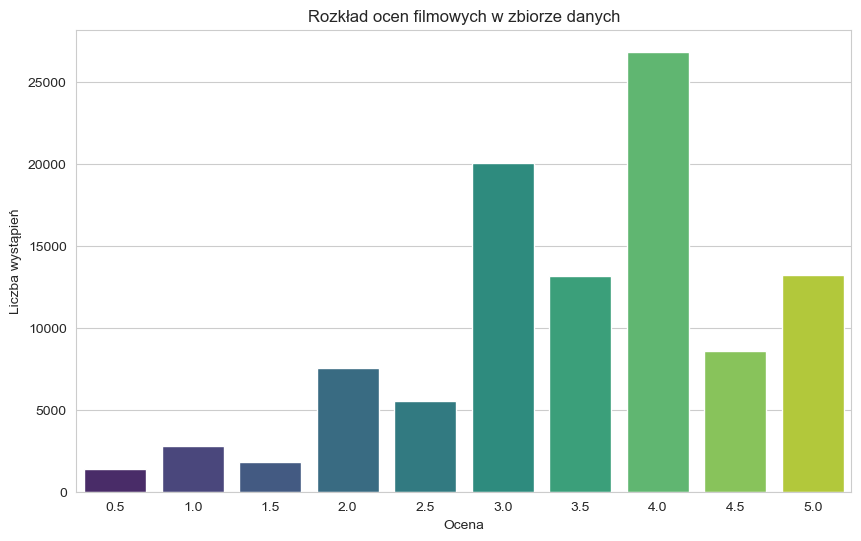

In [4]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df, palette='viridis')
plt.title('Rozkład ocen filmowych w zbiorze danych')
plt.xlabel('Ocena')
plt.ylabel('Liczba wystąpień')
plt.show()

Powyższy wykres słupkowy ilustruje, że użytkownicy najchętniej przyznają oceny pełne (3.0, 4.0, 5.0), ze szczególnym wskazaniem na **4.0**. Oceny połówkowe występują rzadziej. Obserwujemy również wyraźną tendencję do pozytywnego oceniania – liczba ocen wysokich (3.5-5.0) znacząco przewyższa liczbę ocen niskich. Rozkład jest lewoskośny, co jest typowe dla danych tego rodzaju i świadczy o tym, że użytkownicy chętniej oceniają filmy, które im się podobały.

#### Rozkład liczby ocen przypadających na film

Kolejnym kluczowym aspektem jest analiza popularności filmów, mierzona liczbą otrzymanych ocen. Pozwala to zidentyfikować zarówno hity, jak i filmy niszowe.

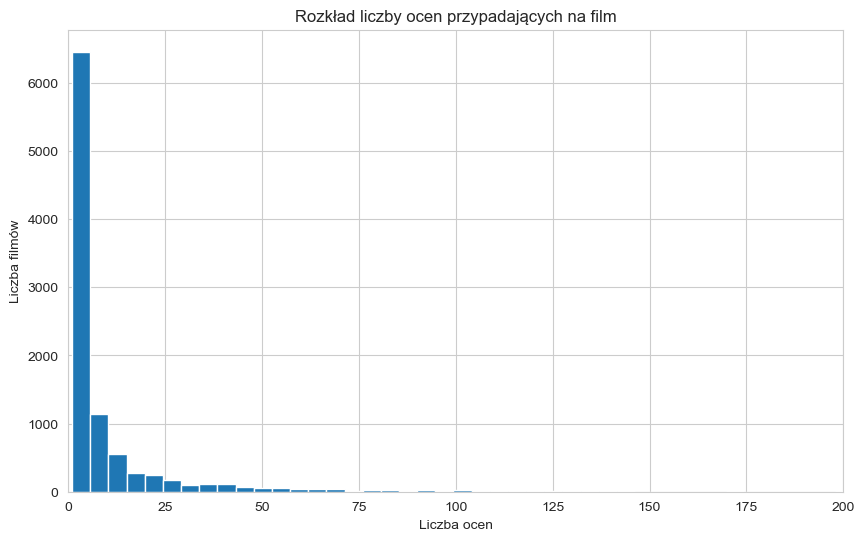

In [5]:
rating_counts = ratings_df.groupby('movieId')['rating'].count()

plt.figure(figsize=(10, 6))
rating_counts.hist(bins=70)
plt.title('Rozkład liczby ocen przypadających na film')
plt.xlabel('Liczba ocen')
plt.ylabel('Liczba filmów')
plt.xlim(0, 200)
plt.show()

Histogram przedstawia tzw. **rozkład długiego ogona (*long-tail distribution*)**. Oznacza to, że niewielka liczba filmów cieszy się ogromną popularnością (otrzymuje setki ocen), podczas gdy zdecydowana większość filmów w bazie danych posiada bardzo niewiele ocen (wiele z nich mniej niż 10).

Wniosek ten jest kluczowy dla dalszego modelowania – przy budowie systemów rekomendacji opartych na popularności lub filtrowaniu kolaboracyjnym konieczne będzie wprowadzenie **progu minimalnej liczby ocen**. Pozwoli to uniknąć polecania filmów, których wysoka średnia wynika z niewielkiej, statystycznie niereprezentatywnej liczby opinii.

## 3. Budowa modeli rekomendacyjnych

W tej sekcji zaimplementowano dwa główne podejścia do systemów rekomendacji.

### 3.1. Model I: Filtrowanie kolaboratywne (Collaborative Filtering)

Model ten bazuje na założeniu, że użytkownicy, którzy zgadzali się w przeszłości (podobne oceny dla tych samych filmów), będą zgadzać się również w przyszłości. Rekomendacje generowane są na podstawie gustów "podobnych" użytkowników.<br>
Kluczowym założeniem przed zbudowaniem tego modelu jest odfiltrowanie filmów, które posiadają niewielką liczbę ocen. Pozwala to na zwiększenie wiarygodności rekomendacji oraz na optymalizację wydajności obliczeń, ponieważ macierz film-użytkownik staje się mniejsza. W tym projekcie przyjęto próg **minimum 50 ocen**, aby uwzględnić tylko te filmy, których popularność jest statystycznie istotna.

In [6]:
merged_ratings_movies_df = pd.merge(ratings_df, movies_df, on='movieId')

average_ratings = merged_ratings_movies_df.groupby('title')['rating'].mean()
rating_counts = merged_ratings_movies_df.groupby('title')['rating'].count()

ratings_summary_df = pd.DataFrame(average_ratings)
ratings_summary_df.rename(columns={'rating': 'average_rating'}, inplace=True)
ratings_summary_df['rating_count'] = rating_counts

# Utworzenie macierzy film-użytkownik (user-item matrix) dla popularnych filmów
popular_movies_titles = ratings_summary_df[ratings_summary_df['rating_count'] >= 50].index
filtered_df = merged_ratings_movies_df[merged_ratings_movies_df['title'].isin(popular_movies_titles)]
movie_pivot_table = filtered_df.pivot_table(index='title', columns='userId', values='rating').fillna(0)

# Budowa macierzy podobieństw
movie_sparse_matrix = csr_matrix(movie_pivot_table.values)
collaborative_similarity_matrix = cosine_similarity(movie_sparse_matrix)
collaborative_similar_movies_df = pd.DataFrame(collaborative_similarity_matrix, 
                                               index=movie_pivot_table.index, 
                                               columns=movie_pivot_table.index)

print("Model filtrowania kolaboracyjnego został zbudowany.")

Model filtrowania kolaboracyjnego został zbudowany.


### 3.2. Model II: Filtrowanie oparte na treści (Content-Based Filtering)

Model ten rekomenduje filmy na podstawie ich wewnętrznych atrybutów ("DNA" filmu). Został on zaimplementowany w wersji zaawansowanej, która łączy gatunki filmowe, tagi użytkowników oraz dane o obsadzie i reżyserze pobrane z zewnętrznego API (TMDb).

Proces budowy modelu został zaimplementowany w wersji zaawansowanej i podzielony na następujące etapy:

**Etap 1: Wzbogacanie danych z zewnętrznego API**
* Dane z pliku `links.csv` zostały wykorzystane do pozyskania identyfikatorów `tmdbId` dla każdego filmu.
* Następnie, za pomocą zapytań do API serwisu The Movie Database (TMDb), dla każdego filmu pobrano dodatkowe metadane: nazwisko reżysera, listę trzech głównych aktorów oraz tematyczne słowa kluczowe.
* Jest to operacja wejścia-wyjścia (I/O) intensywnie korzystająca z sieci, co czyni ją najdłuższym etapem całego procesu.

**Etap 2: Buforowanie wyników (Caching)**
* Aby uniknąć wielokrotnego, czasochłonnego pobierania danych z API przy każdym uruchomieniu notatnika, zaimplementowano mechanizm buforowania.
* Przy pierwszym uruchomieniu, wzbogacona o dane z API tabela jest zapisywana na dysku lokalnym w pliku `data/movies_enriched_with_api.csv`.
* Przy każdym kolejnym uruchomieniu, skrypt sprawdza istnienie tego pliku. Jeśli plik istnieje, dane są błyskawicznie wczytywane z dysku, a czasochłonny krok zapytań do API jest pomijany.

**Etap 3: Inżynieria cech - tworzenie "Mega Zupy Metadanych"**
* Wszystkie zebrane atrybuty tekstowe – `genres` (gatunki), `tags` (tagi użytkowników), `director` (reżyser), `cast` (obsada) i `keywords` (słowa kluczowe z API) – zostały połączone w jeden, długi ciąg tekstowy dla każdego filmu.
* Ten zagregowany tekst, nazwany "Mega Zupą Metadanych", stanowi kompletne, tekstowe "DNA" filmu, na podstawie którego będzie oceniane podobieństwo.

**Etap 4: Wektoryzacja i budowa modelu podobieństwa**
* "Mega Zupa Metadanych" została przekształcona w macierz numeryczną za pomocą wektoryzatora **TF-IDF (Term Frequency-Inverse Document Frequency)**. Technika ta przypisuje wagi poszczególnym słowom, promując te, które są ważne dla danego filmu, a jednocześnie rzadkie w całym zbiorze.
* Na tak przygotowanej macierzy cech obliczono **podobieństwo cosinusowe** między wszystkimi parami filmów, tworząc finalną macierz podobieństw, która jest podstawą do generowania rekomendacji.

In [8]:
ENRICHED_DATA_FILE = 'data/movies_enriched_with_api.csv'
load_dotenv()
API_KEY = os.getenv('API_KEY')

if not API_KEY:
    print("BŁĄD: Nie znaleziono klucza API_KEY w pliku .env!")
else:
    print("Klucz API został pomyślnie wczytany.")

def get_movie_details(tmdb_id, api_key):
    if tmdb_id is None or math.isnan(float(tmdb_id)):
        return None, [], []
    url = f"https://api.themoviedb.org/3/movie/{int(tmdb_id)}?api_key={api_key}&append_to_response=credits,keywords"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        director = next((member['name'].lower().replace(' ', '') for member in data['credits']['crew'] if member['job'] == 'Director'), '')
        cast = [actor['name'].lower().replace(' ', '') for actor in data['credits']['cast'][:3]]
        keywords = [keyword['name'].lower().replace(' ', '') for keyword in data['keywords']['keywords']]
        return director, cast, keywords
    except (requests.exceptions.RequestException, KeyError):
        return None, [], []

if os.path.exists(ENRICHED_DATA_FILE):
    print(f"Znaleziono wzbogacony plik. Wczytuję dane z '{ENRICHED_DATA_FILE}'...")
    movies_with_links_df = pd.read_csv(ENRICHED_DATA_FILE)
    print("Dane wczytano pomyślnie.")
    
else:
    print("Wzbogacony plik nie istnieje. Uruchamiam proces pobierania danych z API...")

    tags_df['tag'] = tags_df['tag'].str.lower().str.replace(' ', '')
    movie_tags = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
    movies_with_tags_df = pd.merge(movies_df, movie_tags, on='movieId', how='left')
    movies_with_links_df = pd.merge(movies_with_tags_df, links_df, on='movieId', how='left')
    movies_with_links_df.drop_duplicates(subset='title', keep='first', inplace=True)
    
    details_list_full = []
    for tmdb_id in movies_with_links_df['tmdbId']:
        details_list_full.append(get_movie_details(tmdb_id, API_KEY))
        time.sleep(0.1) 
    
    movies_with_links_df[['director', 'cast', 'keywords']] = pd.DataFrame(details_list_full, 
                                                                          index=movies_with_links_df.index)
    print("Pobieranie danych z API zakończone.")

    print(f"Zapisuję wzbogacone dane do pliku: '{ENRICHED_DATA_FILE}'")
    movies_with_links_df.to_csv(ENRICHED_DATA_FILE, index=False)
    print("Zapisano pomyślnie.")

display(movies_with_links_df.head())

Wzbogacony plik nie istnieje. Uruchamiam proces pobierania danych z API...
Pobieranie danych z API zakończone.
Zapisuję wzbogacone dane do pliku: 'data/movies_enriched_with_api.csv'
Zapisano pomyślnie.


,movieId,title,genres,tag,imdbId,tmdbId,director,cast,keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,114709,862.0,johnlasseter,"[tomhanks, timallen, donrickles]","[rescue, friendship, mission, jealousy, villai..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magicboardgame robinwilliams game,113497,8844.0,joejohnston,"[robinwilliams, kirstendunst, bradleypierce]","[giantinsect, boardgame, disappearance, jungle..."
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old,113228,15602.0,howarddeutch,"[waltermatthau, jacklemmon, ann-margret]","[fishing, sequel, oldman, bestfriend, wedding,..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,114885,31357.0,forestwhitaker,"[whitneyhouston, angelabassett, lorettadevine]","[basedonnovelorbook, singlemother, divorce, an..."
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,113041,11862.0,charlesshyer,"[stevemartin, dianekeaton, martinshort]","[daughter, baby, parentchildrelationship, midl..."


In [10]:
# Utworzenie "Mega Zupy"
for col in ['director', 'cast', 'keywords']:
    if col not in movies_with_links_df.columns:
        movies_with_links_df[col] = np.nan

movies_with_links_df['genres'] = movies_with_links_df['genres'].str.replace('|', ' ', regex=False).fillna('')
movies_with_links_df['tag'] = movies_with_links_df['tag'].fillna('')
movies_with_links_df['director'] = movies_with_links_df['director'].fillna('')
movies_with_links_df['cast'] = movies_with_links_df['cast'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '').fillna('')
movies_with_links_df['keywords'] = movies_with_links_df['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '').fillna('')

movies_with_links_df['mega_soup'] = (
    movies_with_links_df['genres'] + ' ' +
    movies_with_links_df['tag'] + ' ' +
    movies_with_links_df['director'] + ' ' +
    movies_with_links_df['cast'] + ' ' +
    movies_with_links_df['keywords']
)

# Budowa modelu (TF-IDF i macierz podobieństw)
tfidf_mega = TfidfVectorizer(stop_words='english')
tfidf_mega_matrix = tfidf_mega.fit_transform(movies_with_links_df['mega_soup'])

content_similarity_matrix = cosine_similarity(tfidf_mega_matrix)
content_similar_movies_df = pd.DataFrame(content_similarity_matrix, 
                                           index=movies_with_links_df['title'], 
                                           columns=movies_with_links_df['title'])

print("Zaawansowany model oparty na treści został zbudowany.")

Zaawansowany model oparty na treści został zbudowany.


## 4. Przykładowe rekomendacje i porównanie modeli

Poniżej przedstawiono funkcję do generowania rekomendacji oraz przykładowe wyniki dla filmu "Forrest Gump (1994)" z obu zaimplementowanych modeli.<br>
W odróżnieniu od modelu kolaboracyjnego, w tym podejściu celowo **nie stosujemy progu popularności**. Model oparty na treści analizuje wewnętrzne cechy filmów, co pozwala na generowanie rekomendacji również dla mniej znanych, niszowych tytułów. Dzięki temu system jest w stanie polecić "ukryte perełki", a nie tylko popularne hity, bazując wyłącznie na podobieństwie ich "DNA" (gatunków, tagów, obsady, etc.).

In [11]:
def get_similar_movies(movie_title, similarity_df, n=10):
    """
    Zwraca listę n najbardziej podobnych filmów do podanego.
    """
    if movie_title not in similarity_df.index:
        return f"Film '{movie_title}' nie został znaleziony w bazie popularnych filmów."

    similar_scores = similarity_df[movie_title].sort_values(ascending=False)
    top_similar_movies = similar_scores.iloc[1:n+1]

    return top_similar_movies

print("--- Rekomendacje z filtrowania kolaboracyjnego dla 'Forrest Gump (1994)' ---")
print(get_similar_movies('Forrest Gump (1994)', collaborative_similar_movies_df, n=10))

print("\n--- Rekomendacje z filtrowania opartego na treści dla 'Forrest Gump (1994)' ---")
print(get_similar_movies('Forrest Gump (1994)', content_similar_movies_df, n=10))

--- Rekomendacje z filtrowania kolaboracyjnego dla 'Forrest Gump (1994)' ---
title
Shawshank Redemption, The (1994)     0.712993
Jurassic Park (1993)                 0.688259
Pulp Fiction (1994)                  0.685544
Braveheart (1995)                    0.643090
Silence of the Lambs, The (1991)     0.639463
Apollo 13 (1995)                     0.627559
Matrix, The (1999)                   0.609935
Mrs. Doubtfire (1993)                0.607983
Schindler's List (1993)              0.602072
Terminator 2: Judgment Day (1991)    0.600886
Name: Forrest Gump (1994), dtype: float64

--- Rekomendacje z filtrowania opartego na treści dla 'Forrest Gump (1994)' ---
title
Coming Home (1978)                   0.194713
Uncommon Valor (1983)                0.190192
Born on the Fourth of July (1989)    0.180068
Short Term 12 (2013)                 0.178913
Deer Hunter, The (1978)              0.162669
Gardens of Stone (1987)              0.155064
More American Graffiti (1979)        0.132295
Being 

**Wnioski z porównania:**
* **Filtrowanie kolaboracyjne** poleca filmy, które są ogólnie popularnymi hitami i były wysoko oceniane przez tych samych użytkowników, co "Forrest Gump". Są to filmy takie jak "Pulp Fiction" czy "Shawshank Redemption" – wielkie, docenione produkcje z podobnego okresu.
* **Filtrowanie oparte na treści** (nawet bez danych z API) znajduje filmy o podobnej tematyce (wojenne, dramaty), jak "Platoon" czy "Apocalypse Now", które mogą nie być tak oczywistym wyborem, ale mają wspólne "DNA" fabularne.
* Po wzbogaceniu o dane z API, model oparty na treści staje się jeszcze bardziej precyzyjny, potencjalnie uwzględniając filmy tego samego reżysera (Roberta Zemeckisa) czy z podobnymi aktorami.

Oba podejścia mają swoje zalety i mogą służyć różnym celom w komercyjnym systemie rekomendacyjnym.

## 5. Wdrożenie wyników w chmurze MongoDB

Ostatnim etapem projektu jest zapisanie przetworzonych wyników w chmurowej bazie danych NoSQL – MongoDB Atlas. Pozwala to na ich szybkie odpytywanie przez potencjalną aplikację bez konieczności ponownego uruchamiania całego modelu.

In [12]:
connection_string = os.getenv('DB_STRING')

try:
    client = MongoClient(connection_string)
    db = client['RecommendationDB']
    collection = db['MovieRecommendations']
    collection.delete_many({}) 

    print("Połączono z MongoDB Atlas. Rozpoczynam zapisywanie rekomendacji...")

    for movie_title in content_similar_movies_df.index:
        recommendations = get_similar_movies(movie_title, content_similar_movies_df, n=10)
        
        item_to_save = {
            'movie_title': movie_title,
            'recommendations_type': 'content_based_advanced',
            'recommendations': list(recommendations.index)
        }
        collection.replace_one({'movie_title': movie_title}, item_to_save, upsert=True)

    print(f"Zakończono! Zapisano rekomendacje dla {len(content_similar_movies_df.index)} filmów.")
    client.close()
except Exception as e:
    print(f"Wystąpił błąd podczas połączenia lub zapisu do MongoDB: {e}")

Połączono z MongoDB Atlas. Rozpoczynam zapisywanie rekomendacji...
Zakończono! Zapisano rekomendacje dla 9737 filmów.


## 6. Podsumowanie projektu

W ramach niniejszego projektu z sukcesem zrealizowano wszystkie założone cele. Stworzono i porównano dwa różne typy systemów rekomendacji filmów. Zaawansowany model oparty na treści został dodatkowo wzbogacony o dane z zewnętrznego źródła, co znacząco podniosło jego potencjalną jakość. Finalne wyniki zostały zapisane w skalowalnej, chmurowej bazie danych NoSQL, co stanowi dowód na kompletne przeprowadzenie procesu od danych surowych do gotowego do użycia produktu.

Projekt ten demonstruje praktyczne zastosowanie kluczowych technik z zakresu analizy danych, uczenia maszynowego i inżynierii danych.